# Assignment 7 (Nov 2)

Today's topics are:

1. Efficiency, indexing, vectorization
2. Timing code
3. Using vectorized functions/methods
4. Easy parallelization with Numba

## Readings (optional)

If you find this week's material new or challenging, you may want to read through some or all the following resources while working on your assignment:



In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Efficiency, indexing, vectorization

Now that we've learned several workflows in Python, some of which can take a long time (Monte Carlo methods and MCMC), we are going to talk about:

- how to time your code
- how to estimate how long your code will take (and when you can't)
- how to use indexing / vectorization to avoid slow loops
- how to use Numba to speed up slow loops


### Timing code

To understand how fast / efficient our code is, we will first need to learn how long our code takes to run.

The most basic way to time code is using the built-in Python `time` module.

The function `time.time()` gives us a timestamp from when it is called. This timstamp is a number in seconds with ~microsecond (6 decimal) precision on Linux / Mac.

Note: The precision of `time` on Windows is actually closer to 0.01 seconds in practice, so be careful comparing very short time periods.

In [3]:
import time

n = 10000000
time_start = time.time()
x = np.random.rand(n)
y = np.sort(x)
time_end = time.time()

time_delta = time_end - time_start
print(f"Time to sort {n:.0e} numbers: {time_delta:.3f} s")

Time to sort 1e+07 numbers: 1.449 s


Try re-running the above cell several times. 

You should notice that the timing for each run changes slightly. This can be due to:

- How much work there is to do (e.g. since randomness is involved)
- How many background tasks are running on your computer when you run the cell

To get an accurate estimate of how long our code takes to run, as scientists we can run an experiment by:

1.  Closing all background programs so only Python is running
2.  Time our code chunk several times
3.  Take the average and standard deviation of all of the runs

In [4]:
n = 10000000
timings = []

for i in range(10):
    time_start = time.time()
    x = np.random.rand(n)
    y = np.sort(x)
    time_end = time.time()
    time_delta = time_end - time_start
    print(f"Run {i} Time to sort {n:.0e} numbers: {time_delta:.3f} s")
    timings.append(time_delta)

time_mean = np.mean(timings)
time_std = np.std(timings)
print(f"Avg time to sort {n:.0e} numbers: {time_mean:.3f} +/- {time_std:.3f} s (ntrials: {len(timings)})")

Run 0 Time to sort 1e+07 numbers: 1.621 s
Run 1 Time to sort 1e+07 numbers: 1.488 s
Run 2 Time to sort 1e+07 numbers: 1.585 s
Run 3 Time to sort 1e+07 numbers: 1.715 s
Run 4 Time to sort 1e+07 numbers: 1.631 s
Run 5 Time to sort 1e+07 numbers: 1.680 s
Run 6 Time to sort 1e+07 numbers: 1.474 s
Run 7 Time to sort 1e+07 numbers: 1.545 s
Run 8 Time to sort 1e+07 numbers: 1.661 s
Run 9 Time to sort 1e+07 numbers: 1.457 s
Avg time to sort 1e+07 numbers: 1.586 +/- 0.086 s (ntrials: 10)


Conveniently, the **IPython** framework that Jupyter runs on has some built-in functions for timing code. Called *IPython magics*, we can invoke them with `%` and the main ones we'll use are `time` and `timeit` (See all IPython magics [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html)).

In [5]:
%%time

x = np.random.rand(n)
y = np.sort(x)

CPU times: user 1.49 s, sys: 90.3 ms, total: 1.58 s
Wall time: 1.57 s


Here we get a dew outputs, but the one we care about is **Wall time** (the total time to runn the cell).

While `%%time` will time an entire cell If we want to time a specific line of code, we can use `%time` instead:

In [6]:
x = np.random.rand(n)
%time y = np.sort(x)

CPU times: user 1.4 s, sys: 29.8 ms, total: 1.43 s
Wall time: 1.43 s


We saw above that we often want to run our code multiple times to get the average runtime. We can do this with the `%%timeit` magic.

In [7]:
%%timeit

x = np.random.rand(n)
y = np.sort(x)

1.45 s ± 50.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Built-in vectorized methods

Here we will use what we learned about timing code to investigate a few different ways of computing the maximum of a list / array. Our four options for computing the max are:

1. Using a for loop
2. Python built-in `max()` 
3. NumPy function `np.max()`
4. NumPy array method `np.ndarray.max()`

First let's set up an example array to pull the maximum from:

In [9]:
arr = np.array([1, 7, 2, 9, 1, 2, 3, 0, 4, 8])

Now let's show our 4 options of computing the max and make sure they work!

In [10]:
def max_loop(arr):
    """
    Return the maximum value in an array.
    """
    maxval = arr[0]
    for val in arr:
        if val > maxval:
            maxval = val
    return maxval

# 1. For loop
max1 = max_loop(arr)
print(f"For loop: {max1}")

# 2. Python max()
max2 = max(arr)
print(f"Python max(): {max2}")

# 3. NumPy np.max()
max3 = np.max(arr)
print(f"NumPy np.max(): {max3}")

# 4. NumPy array.max()
max4 = arr.max()
print(f"NumPy array.max(): {max4}")

For loop: 9
Python max(): 9
NumPy np.max(): 9
NumPy array.max(): 9


Now we have 4 ways of computing the maximum of an array, but we'll have to test on much longer arrays to start to see differences in speed. Let's use `np.random` to make a long random array.

Let's also time our loop function with the `%%timeit` IPython magic (see [docs](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)).

Remember: `%%magic` is for a whole cell, `%magic` is when using inline.

In [11]:
%%timeit

seed = 999  # Change for different random results
rng = np.random.default_rng(seed)  # Init RNG
ndraws = 1000000  # Number of random numbers to generate

# Random array of length ndraws (values between 0 and 1)
arr = rng.random(ndraws)

max1 = max_loop(arr)

110 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Q: What is wrong with the above example?

Hint: Recall we want to time the `max_loop` function only.

A: What we're actually timing above is the entire cell, including making our random array. If we want a fair comparison between our max methods, we need to isolate only the work of each function.

Let's use the inline `%timeit` to time our 4 max functions.

In [12]:
# Compute this ahead of time so we don't time it
seed = 999  # Change for different random results
rng = np.random.default_rng(seed)  # Init RNG
ndraws = 1000000  # Number of random numbers to generate

# Random array of length ndraws (values between 0 and 1)
arr = rng.random(ndraws)

# Time our 4 different methods
print('1. For loop')
max1 = %timeit max_loop(arr)

print('\n2. Python max()')
max2 = %timeit max(arr)

print('\n3. NumPy np.max()')
max3 = %timeit np.max(arr)

print('\n4. NumPy array.max()')
max4 = %timeit arr.max()

1. For loop
102 ms ± 9.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

2. Python max()
79.9 ms ± 8.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

3. NumPy np.max()
667 µs ± 32.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

4. NumPy array.max()
602 µs ± 27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Seems like we have our ranking!

1. `np.array.max()` faster than `np.max()` but within errors
2. Python `max()`
3. for loop

We should get the same ranking if we feed in a Python list `[]` rather than NumPy array right?

Let's try it:

In [13]:
# Compute this ahead of time so we don't time it
seed = 999  # Change for different random results
rng = np.random.default_rng(seed)  # Init RNG
ndraws = 1000000  # Number of random numbers to generate

# Random array of length ndraws (values between 0 and 1)
arr = rng.random(ndraws)
lst = list(arr)

# Time our 4 different methods
print('1. For loop')
max1 = %timeit max_loop(lst)

print('\n2. Python max()')
max2 = %timeit max(lst)

print('\n3. NumPy np.max()')
max3 = %timeit np.max(lst)

print('\n4. NumPy array.max()')
max4 = %timeit np.array(lst).max()

1. For loop
52.7 ms ± 7.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

2. Python max()
31.1 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

3. NumPy np.max()
53.4 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

4. NumPy array.max()
54 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


What happened here? It seems like the ranking switched:

1. Python `max()`
2. `np.max()` faster than `np.array.max()` but within errors
3. for loop

This brings up an interesting subtlety about coding in Python (and in general):

**The data structure you choose can affect the efficiency of your program**

Why is this happening? To find out, we'll notice 2 things about our timings.

1. The `np.max` and `np.array.max()` methods were faster on NumPy arrays
2. The built-in Python `max` method was faster on the Python list `[]`

We could chalk this up to a platitude like, 

*"Python `max()` is optimized for Python lists, while `np.max()` is optimized for NumPy arrays"*. 

While this is partially true, if we understand the differences between lists and arrays, we can see there's a bit more going on here.

| Python list | NumPy array |
| - | - |
| Can contain any object | Contains numerical data |
| No fixed type (size) of elements | Fixed data type (size) of elements |
| No `.max()` method | Has `.max()` method defined |

Let's verify the data type of our NumPy array:

In [31]:
arr.dtype

dtype('float64')

The fact that a NumPy array has a fixed data type and a defined length means that functions like `np.max()` can take advantage of super fast low-level algorithms (which run as compiled `C` code) to search, do math, comparisons, etc on our array.

When a NumPy array is created, it blocks out a certain chunk of your computer's memory so that all future operations on the array are speedy! BUT this takes a bit of time to save time later.

To find a maximum, all of our methods need to look at every element in the list/array, BUT NumPy is faster for 2 reasons:

- it blocks off a place in memory 
- the max function can very quickly in **C**

So why aren't the NumPy functions faster on lists as well?

As you can see in the line `%timeit np.array(lst).max()`, the Python list had no `.max()` so we had to first *convert the data type* from list to NumPy array and then call `.max()`. This is also what is happening below the hood when we call `np.max(lst)` on a regular list.

So the reason Python `max()` is slower on arrays is that NumPy has to block off memory and then convert the list to an array (which takes time), before running the speedier NumPy algorithm on it. Overall, converting to an array and then finding the max is slower than just finding the max (like Python does with `max()`).

This leads us to our rules of thumb for efficient science code:

## Efficiency rules of thumb

1. Use the proper data structure for the job
  - NumPy arrays are suited for numerical data
  - Pandas DataFrames are suited for table data
  - Python Lists are suited to non-numerical or mixed type data
2. Use the optimized built-in functions
  - Use NumPy's functions/methods on arrays
  - Use the Pandas methods on DataFrames
3. Avoid converting back and forth between data types
  - Keep your numerical data in NumPy arrays wherever possible
  - Keep your table data in DataFrames wherever possible
  - If you need to use a loop, allocate your arrays (e.g with `np.zeros`) ahead of time rather than appending to a list and converting to an array later
4. Avoid custom Python loops wherever possible (see rule 2)

## Time scaling

The **scaling** behavior of our code describes how quickly it runs as the inputs get larger. Let's use our max situation again.

There were 8 situations total:

1. np.max(array) and np.max(list)
2. array.max() and np.array(list).max()
3. max(array) and max(list)
4. max_loop(array) and max_loop(list)

Let's look at the best from each category we identified before, so:

1. np.max(array)
2. array.max()
3. max(list)
4. max_loop(list)

To investigate the scaling behavior, we will run the timing code with increasing `ndraws` (length of random array).

**Note:** Most operations (like max) will take exponentially longer as the array size increases. For now, we will only show `ndraws = [10, 100, 1000]`, but will use parallel programming (multiprocessing) later to speed things up!

In [14]:
seed = 999  # Change for different random results
rng = np.random.default_rng(seed)  # Init RNG
ndraws_list = [1, 10, 100, 1000]  # Number of random numbers to generate

timings = np.zeros((len(ndraws_list), 4))
for i, ndraws in enumerate(ndraws_list):
    arr = rng.random(ndraws)
    lst = list(arr)

    t1 = %timeit -o -q max_loop(lst)
    timings[i, 0] = t1.average
    t2 = %timeit -o -q max(lst)
    timings[i, 1] = t2.average
    t3 = %timeit -o -q np.max(arr)
    timings[i, 2] = t3.average
    t4 = %timeit -o -q arr.max()
    timings[i, 3] = t4.average


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


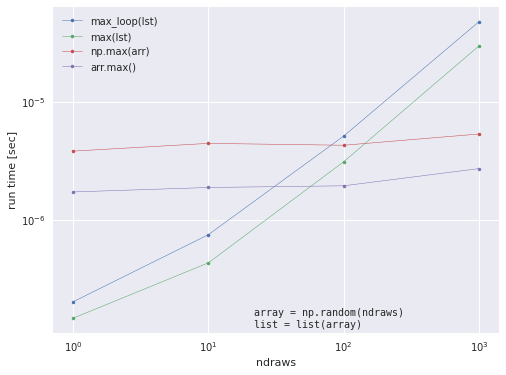

In [15]:
label_names = ['max_loop(lst)', 'max(lst)', 'np.max(arr)', 'arr.max()']

# plot the data
f = plt.figure(facecolor='white', figsize=(8, 6))
ax = plt.subplot(111)

for i, label in enumerate(label_names):
    ax.plot(ndraws_list, timings[:, i], '.-', lw=.5, label=label)

ax.set_xlabel('ndraws', fontname='Helvetica')
ax.set_ylabel(r'run time [sec]', fontname='Helvetica')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.text(0.45, 0.01, "array = np.random(ndraws)\nlist = list(array)", ha='left', 
        va='bottom', transform=ax.transAxes, family='monospace')

plt.show()

## Parallel computing (multiprocessing)

Reading:
* [A beginners guide to Multi-Processing in Python](https://www.analyticsvidhya.com/blog/2021/04/a-beginners-guide-to-multi-processing-in-python/)

Two ways to use multiprocessing:

* python build-in function: `multiprocessing`
* [Parallel TQDM (pqdm)](https://pqdm.readthedocs.io/en/latest/readme.html)


To get pqdm, activate your conda environment and run:

`conda install -c conda-forge pqdm`

It will come with the dependency, `tqdm` which means "progress" in Arabic ([see docs here](https://tqdm.github.io)).

The main function of `tqdm` is to have a progress bar for your loops. Just wrap your loop iterable e.g. `tqdm(range(10))` and you'll see a progress bar with the average time to run each iteration and estimated total run time.

In [5]:
from tqdm import tqdm
import time

for i in tqdm(range(10)):
    # Choose random sleep time between 0 and 3 seconds
    time.sleep(np.random.randint(0, 3))

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


For `pqdm`, the "Parallel" `tqdm`, we can time our loops but also run them in parallel.


In [12]:
from pqdm.processes import pqdm
# If you want threads instead:
# from pqdm.threads import pqdm

args = np.arange(50)
# args = range(1,6) would also work

def square(a):
    return a*a

In [10]:
%%time

result = []
for a in args:
    result.append(a*a)

print(result)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401]
CPU times: user 442 µs, sys: 94 µs, total: 536 µs
Wall time: 437 µs


In [11]:
%%time

result = pqdm(args, square, n_jobs=2)
print(result)

SUBMITTING | :   0%|          | 0/50 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/50 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/50 [00:00<?, ?it/s]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401]
CPU times: user 255 ms, sys: 114 ms, total: 369 ms
Wall time: 294 ms


Now it time to use multiprocessing to run through the whole list `ndraws_list = [10, 100, 1000, 10000, 100000, 1000000]`

In [13]:
rng = np.random.default_rng(999)
ndraws_list = [10, 100, 1000]#, 10000, 100000, 1000000]

def run_timeit(i):
    ndraws = ndraws_list[i]
    
    rng = np.random.default_rng(999)
    # numpy array
    ramdon_array = rng.random(ndraws)
    # python list
    ramdon_list = list(ramdon_array)
    
    run_time_box = np.zeros(5)

    r1 = %timeit -o -q np.max(ramdon_array)
    run_time_box[0] = r1.average
    r2 = %timeit -o -q ramdon_array.max()
    run_time_box[1] = r2.average
    r3 = %timeit -o -q max(ramdon_array)
    run_time_box[2] = r3.average
    r4 = %timeit -o -q np.max(ramdon_list)
    run_time_box[3] = r4.average
    r5 = %timeit -o -q max(ramdon_list)
    run_time_box[4] = r5.average
    
    return run_time_box 


In [14]:
# you can open your terminal and use `top` or `htop` to see the cpu useage. 
outs = pqdm(np.arange(len(ndraws_list)), run_timeit, n_jobs=6)

SUBMITTING | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/3 [00:00<?, ?it/s]

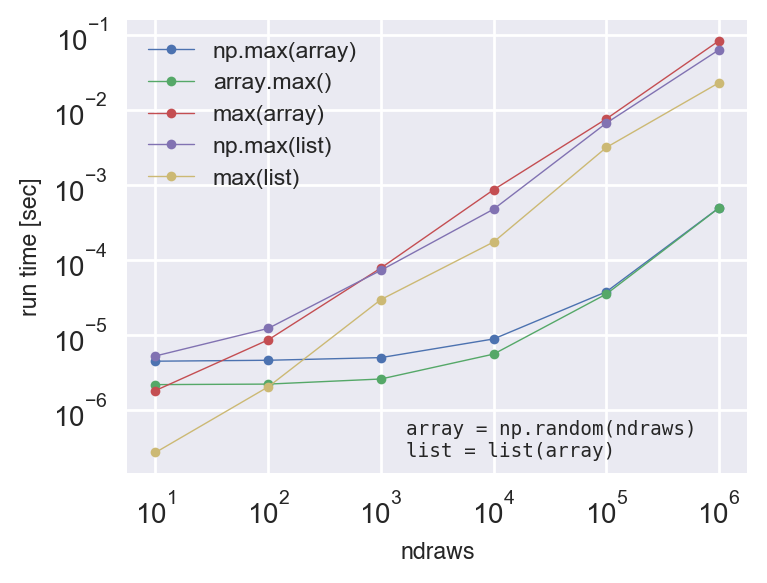

In [14]:
# transfer list to array
run_time_box = np.array(outs)

label_names = ['np.max(array)', 'array.max()', 'max(array)', 'np.max(list)', 'max(list)']

# plot the data
f = plt.figure(facecolor='white', figsize=(4,3), dpi=200 )
ax = plt.subplot(111)

for i, l in zip(range(5), label_names):
    ax.plot(ndraws_list, run_time_box[:, i], '.-', lw=.5, label=l)

ax.set_xlabel('ndraws', size='small', fontname='Helvetica')
ax.set_ylabel(r'run time [sec]', size='small', fontname='Helvetica')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize='small')
ax.text(0.45, -0.02, '''
array = np.random(ndraws)
list = list(array)
''', ha='left', va='bottom', size='x-small', transform = ax.transAxes, 
family='monospace')

plt.show()

## Numba

Here, we will give a quick example of how to use a package called `numba` to automatically compile your Python code to **C** which can *magically* speed up your code.

We highly recommend checking out this more detailed [Introduction to Numba](https://nyu-cds.github.io/python-numba/) by New York University. It has step by step tutorial like this textbook and practice problems as well.

Other Numba resources:

- [Numba docs: 5 minute guide to Numba](https://numba.pydata.org/numba-doc/latest/user/5minguide.html)
- [Data Frog blog: Make Python Fast with Numba](https://thedatafrog.com/en/articles/make-python-fast-numba/)
- [NumPy supported functions in Numba](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html)

The example we will use is the Monte Carlo calculation of pi we did before!

Let's time our original solutions first (for loop and vectorized).

In [9]:
# Use this number of draws for our MC examples
n_draws = int(1e8)

### Method 1: Python code only (for loop, no NumPy, no Numba)

To solve our problem with only Python, we will have to use the built-in `random` module in Python.

In [12]:
import random
def python_pi(n): 
  n_in_circle = 0 
  for _ in range(n):
    x = random.random()
    y = random.random()
    if (x**2 + y**2 < 1):
      n_in_circle += 1
  return 4*n_in_circle / n

%timeit -r 4 python_pi(n_draws)

41.6 µs ± 3.1 µs per loop (mean ± std. dev. of 4 runs, 10000 loops each)
np.pi: 3.14159265


NameError: name 'pi1' is not defined

### Method 2: Use NumPy random (for loop, NumPy, no Numba)

Here we will use the NumPy basic random functions `np.random.random()`. Normally we want to use a RNG object, but we'll skip it for the sake for this example.

In [ ]:
import numpy as np
def numpy_pi(n): 
  n_in_circle = 0 
  for _ in range(n):
    x = np.random.random()
    y = np.random.random()
    if (x**2+y**2 < 1):
      n_in_circle += 1
  return 4*n_in_circle / n

%timeit -r 4 numpy_pi(n_draws)

### Method 3: Use NumPy arrays (vectors, NumPy, no Numba)

Here, we will skip the for loop entirely. We make our x and y random arrays and feed them into our equation of a circle directly. This is the **vectorized** solution.

In [25]:
def numpy_vector_pi(n): 
    x = np.random.random(n)
    y = np.random.random(n)
    n_in_circle = len(np.where(x**2+y**2 < 1)[0])
    return 4*n_in_circle / n
%timeit -r 4 numpy_vector_pi(n_draws)

455 ms ± 71.5 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)


We can gain a little speed by avoiding creating intermediate arrays `x` and `y`, as well as using the simple sum of the `True` values in our equation rather than `np.where`.

In [26]:
def numpy_vector_pi(n): 
    n_in_circle = np.sum(np.random.random(n)**2 + np.random.random(n)**2 < 1)
    return 4*n_in_circle / n
%timeit -r 4 numpy_vector_pi(n_draws)

253 ms ± 14.1 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)


This vectorized solution is about as quick as we can get just with Python / NumPy.

### Method 4: Use Numba to speed up Python loop (for loop, no NumPy, Numba)

Numba has 2 main **decorators** that we can use to magically translate our function to compiled **C** code:

1. `jit`: basic
2. `njit`: "no python" mode, skips Python things

Note: A decorator is a special type of function that changes the behavior of another function. We use a decorator with the `@` symbol on the line before a function definition, e.g.:

```python
@decorator
def func():
    # do stuff
```

The `njit` is a short form for `jit(nopython=True)`. This is usually the one we want (Numba will automatically change `njit` to `jit` if it needs to).

In [29]:
@njit  # same as using @jit(nopython=True)
def fast_pi(n): 
  n_in_circle = 0 
  for _ in range(n):
    x = random.random()
    y = random.random()
    if (x**2+y**2 < 1):
      n_in_circle += 1
  return 4*n_in_circle / n
%timeit -r 4 fast_pi(n_draws)

1.29 s ± 27 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)


### Method 5: Use Numba with NumPy loop (for loop, NumPy, Numba)

Here we'll try using Numba on the Method 2 example.

In [27]:
@njit
def numpy_pi(n): 
  n_in_circle = 0 
  for _ in range(n):
    x = np.random.random()
    y = np.random.random()
    if (x**2+y**2 < 1):
      n_in_circle += 1
  return 4*n_in_circle / n

%timeit -r 4 numpy_pi(n_draws)

1.36 s ± 31.2 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)


### Method 7: Use Numba with vectorized code (vector, NumPy, Numba)

Here we will use Numba on Method 3.

In [28]:
@njit
def numpy_vector_pi(n): 
    n_in_circle = np.sum(np.random.random(n)**2 + np.random.random(n)**2 < 1)
    return 4*n_in_circle / n
%timeit -r 4 numpy_vector_pi(n_draws)

3.14 s ± 990 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)


### Method 8: Use Numba in parallel (for loop, NumPy, Numba parallel)

We can add the option `(parallel=True)` to our Numba decorators to have it parallelize our loop automatically.

One thing we have to do here is define our output array ahead of time so Numba knows where to store the parallel results.

In [17]:
@njit(parallel=True)
def numba_parallel_pi(n): 
  n_in_circle = np.zeros(n)
  for i in range(n):
    x = np.random.random()
    y = np.random.random()
    if (x**2+y**2 < 1):
      n_in_circle[i] = 1
  return 4*np.sum(n_in_circle) / n

%timeit -r 4 numba_parallel_pi(n_draws)

3.14181796

So it seems parallelization doesn't always speed up our work. The main reason is **overhead**. 

**Overhead** is the extra time introduced by our clever speedup techniques. Some of the hidden overhead in the above examples were:

- Creating a large NumPy array
- Having Numba convert our code to **C**
- Having Numba parallelize our code (send it to different processes and wait for a result)

If the work we are doing is really easy, the **overhead** we introduce by running it through Numba or parallelizing it can take just as long or longer than the work itself!

This is why it is important to be able to run quick timing tests with small parts of our code before we dedicate a lot of time to making it more efficient!